In [2]:
import numpy as np
import torch
import deeplay as dl
import torchvision
import PIL
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import os
#CV + tune CNN
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:

def read_mnist_txt(file_path):
    """Read MNIST-like data from text file"""
    images = []
    labels = []
    
    with open(file_path, 'r') as file:
        for line in file:
            if not line.strip():
                continue
            parts = line.strip().split()
            image_num = parts[0].strip('"')
            label = int(parts[1])
            
            # Validate label range
            if label < -9 or label > 9:
                raise ValueError(f"Invalid label {label} found in the dataset.")
            
            pixels = list(map(float, parts[2:]))
            pixel_array = np.array(pixels).reshape(16, 16)
            images.append(pixel_array)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validate(random_state, images, labels, train_fn, predict_fn, k_folds=5, metric_fn=accuracy_score):
    """
    Generic cross-validation.

    Args:
        images (np.ndarray): Image data.
        labels (np.ndarray): Corresponding labels.
        train_fn (callable): Function to train a model. Signature: (train_images, train_labels) -> model
        predict_fn (callable): Function to predict. Signature: (model, test_images) -> predictions
        k_folds (int): Number of folds (default 5).
        metric_fn (callable): Evaluation metric function. Signature: (true_labels, predicted_labels) -> float

    Returns:
        List of scores for each fold.
    """
    all_scores = []
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = random_state)

    for fold, (train_idx, val_idx) in enumerate(kf.split(images)):

        train_images, val_images = images[train_idx], images[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]

        # Train and predict
        model = train_fn(train_images, train_labels)
        predictions = predict_fn(model, val_images)

        # Score
        score = metric_fn(val_labels, predictions)
        all_scores.append(score)

    return all_scores


In [5]:

class MNISTDataset(Dataset):
    """Custom Dataset for MNIST-like data"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL Image for compatibility with torchvision transforms
        image = Image.fromarray(image.astype('float32'))
        
        if self.transform:
            image = self.transform(image)
        
        # Shift labels to zero-based indexing
        label = torch.tensor(label + 9, dtype=torch.long)
        
        return image, label

def create_cnn_model():
    """Create CNN model using deeplay"""
    conv_base = dl.ConvolutionalNeuralNetwork(
        in_channels=1, 
        hidden_channels=[16, 16, 32], 
        out_channels=32,
    )
    conv_base.blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size=2)

    connector = dl.Layer(torch.nn.AdaptiveAvgPool2d, output_size=1)

    # Update out_features to 19 for labels -9 to 9
    dense_top = dl.MultiLayerPerceptron(
        in_features=32,
        hidden_features=[64],
        out_features=19,  # Updated
        out_activation=torch.nn.LogSoftmax(dim=1)
    )

    return dl.Sequential(conv_base, connector, dense_top)

def train_cnn(train_images, train_labels, lr, epochs=20):
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    cnn = create_cnn_model()

    class MNISTClassifier(dl.Classifier):
        def __init__(self, model, optimizer):
            super().__init__(model=model, optimizer=optimizer)
            self.loss_fn = torch.nn.NLLLoss()

        def training_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self.model(x)
            loss = self.loss_fn(y_hat, y)
            return loss

    classifier = MNISTClassifier(model=cnn, optimizer=dl.RMSprop(lr)).create()

    trainer = dl.Trainer(
        max_epochs=epochs,
        accelerator="auto",
        logger=False,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=False
    )

    # Suppress stdout/stderr completely
    with suppress_output():
        trainer.fit(classifier, train_loader)

    return classifier




# Prediction function
def predict_with__cnn(classifier, test_images):
    """Use trained classifier to make predictions on test_images."""
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Dummy labels for test set
    test_dataset = MNISTDataset(test_images, np.zeros(len(test_images)), transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Get predictions
    test_labels = []
    classifier.eval()
    with torch.no_grad():
        for x, _ in test_loader:
            y_hat = classifier.model(x)
            preds = torch.argmax(y_hat, dim=1)
            test_labels.extend((preds - 9).cpu().numpy().tolist())  # Adjust if needed

    return test_labels

import os
import sys
import contextlib

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


1
3
5
10
20
30
50
100


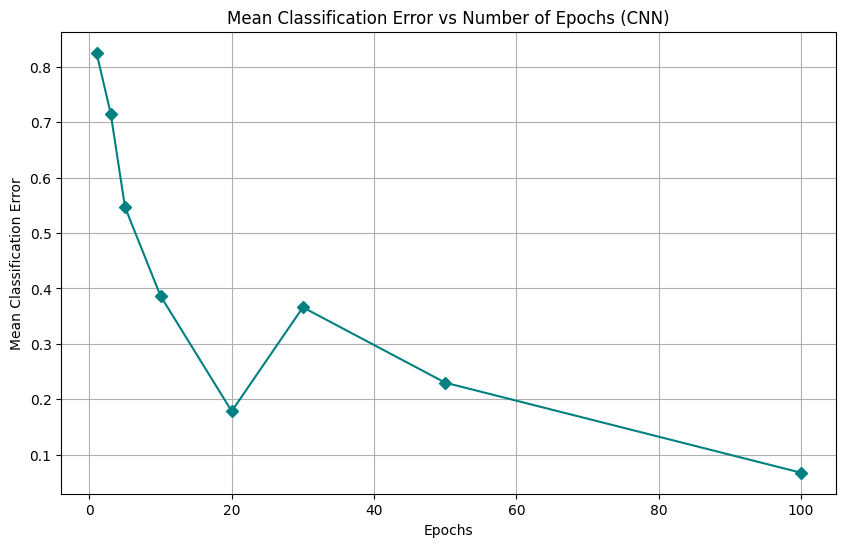

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch

# Define the number of epochs to test
epoch_values = [1, 3, 5, 10, 20,30, 50, 100, 200]
repeats = 1
errors_by_epoch = []

# Load data
images, labels = read_mnist_txt("Numbers.txt")
all_results = []
for epochs in epoch_values:
    print(epochs)
    scores_e = []

    for rep in range(repeats):
        scores = cross_validate(
            random_state=42 + rep,
            images=images,
            labels=labels,
            train_fn=lambda X, y: train_cnn(X, y, lr=0.001, epochs=epochs),
            predict_fn=predict_with__cnn,
            k_folds=5,
            metric_fn=accuracy_score
        )
        scores_e.extend(scores)

    all_results.append(scores_e)

cnn_errors = [1 - np.mean(scores) for scores in all_results]

plt.figure(figsize=(10, 6))
plt.plot(epoch_values, cnn_errors, marker='D', linestyle='-', color='teal')
plt.title("Mean Classification Error vs Number of Epochs (CNN)")
plt.xlabel("Epochs")
plt.ylabel("Mean Classification Error")
plt.grid(True)
plt.show()

C:\Users\Nils\AppData\Local\Temp\ipykernel_4024\3416045621.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(epoch_error_results, labels=epoch_values, showfliers=False)


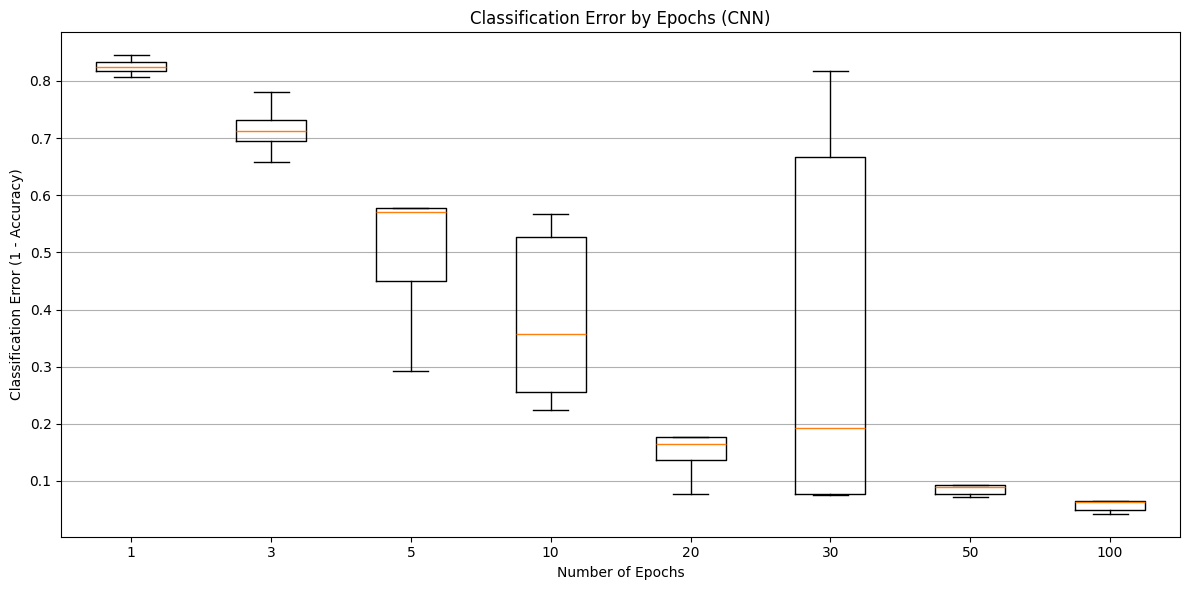

In [10]:
# Convert accuracy scores to classification errors (1 - accuracy)
epoch_error_results = [[1 - score for score in scores] for scores in all_results]

# Plot boxplot for classification error
plt.figure(figsize=(12, 6))
plt.boxplot(epoch_error_results, labels=epoch_values, showfliers=False)
plt.title("Classification Error by Epochs (CNN)")
plt.xlabel("Number of Epochs")
plt.ylabel("Classification Error (1 - Accuracy)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
